---
INF2178 End-of-term Project Code Submission - Group 16
*   Rongjia Bao
*   Xiaozhou (Andy) Ye

https://colab.research.google.com/drive/1Yk0OXL1wc80uuA-Ch4FIkGGxIe1JpP02?usp=sharing
---

Data Import and Cleaning

In [ ]:
# Load useful packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.power import TTestIndPower
!pip install pingouin
from pingouin import ancova
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline
pd.options.display.max_columns = None

In [2]:
# Define a function for data cleaning
def cleandata(filename):
  """Take in csv file name in the format 'file_name.csv', change categorical
  variable columns and binary ordinal variable into string type, and return
  cleaned dataframe.
  """
  # Load data
  df = pd.read_csv(filename)
  # Change categorical variables to string type
  df[['Arrest_Month', 'Perceived_Race', 'Sex', 'Age_group__at_arrest_', \
      'Youth_at_arrest__under_18_years', 'ArrestLocDiv', \
      'Occurrence_Category']] = \
      df[['Arrest_Month', 'Perceived_Race', 'Sex', 'Age_group__at_arrest_', \
          'Youth_at_arrest__under_18_years', 'ArrestLocDiv', \
          'Occurrence_Category']].astype('string')
  # Omit rows where sex is not female or male
  df = df[df['Sex'] != 'U']
  # Modify youth column to either youth or not a your
  df.loc[df['Youth_at_arrest__under_18_years'] != 'Not a youth', \
         'Youth_at_arrest__under_18_years'] = 'Youth'
  # Combine two similar categories for age group into one
  df.loc[df['Age_group__at_arrest_'] == 'Aged 17 years and younger',\
         'Age_group__at_arrest_'] = 'Aged 17 years and under'
  df.loc[df['Age_group__at_arrest_'] == 'Aged 65 and older',\
         'Age_group__at_arrest_'] = 'Aged 65 years and older'
  # When one is strip searched, he/she must be booked at the station
  df.loc[df['StripSearch'] == 1, 'Booked'] = 1
  return df
# Import the data
df = cleandata('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')

# Group the dataset by Year, Race, and Age and calculate the number of
# StripSearch and Arrest
data = df.groupby(['Arrest_Year', 'Perceived_Race', \
                   'Sex', 'Age_group__at_arrest_', \
                   'Youth_at_arrest__under_18_years'], \
                  as_index=False)['StripSearch'].sum()
data['Arrest'] = list(df.groupby(['Arrest_Year', 'Perceived_Race', \
                                  'Sex', 'Age_group__at_arrest_', \
                                  'Youth_at_arrest__under_18_years']).size())
# Simplify the column names
data.rename(columns = {'Arrest_Year': 'Year', 'Perceived_Race': 'Race',
                       'Age_group__at_arrest_': 'AgeGroup',
                       'Youth_at_arrest__under_18_years': 'Youth'},
            inplace = True)

# Add the missing group
newrow = {'Year': 2020,
          'Race': 'Latino',
          'Sex': 'F',
          'AgeGroup': 'Aged 55 to 64 years',
          'Youth': 'Not a youth',
          'StripSearch': 0,
          'Arrest': 0}
data = data.append(newrow, ignore_index = True)
# Evaluate the proportion of strip search in each group
data['Prop_StripSearch'] = data['StripSearch'] / data['Arrest']
data['Prop_StripSearch'] = data['Prop_StripSearch'].fillna(0)

<ipython-input-2-4cf8fd6a02d6>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(newrow, ignore_index = True)


Exploratory Data Analysis

In [19]:
# Describe data
data.head()
df.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,StripSearch,Booked,Occurrence_Category,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,0,1,Assault & Other crimes against persons,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,0,1,Assault & Other crimes against persons,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,0,1,Assault & Other crimes against persons,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,0,0,Harassment/Threatening,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,0,1,FTA/FTC/Compliance Check/Parollee,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5


Text(42.0821875, 0.5, 'Portion of people strip searched')

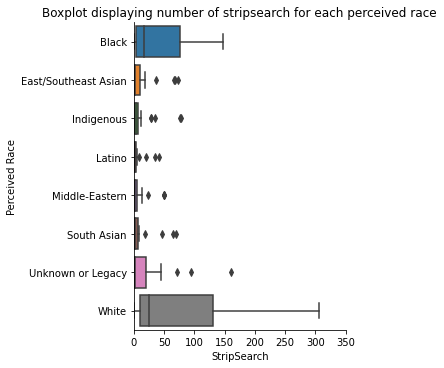

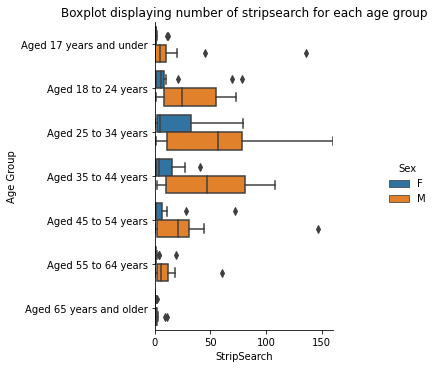

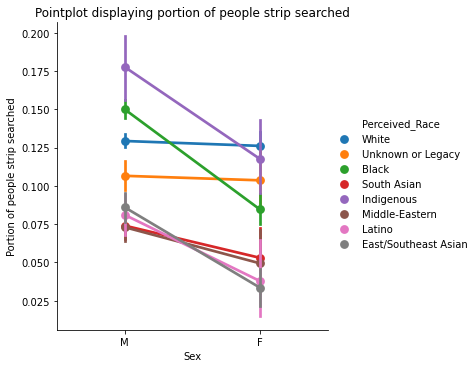

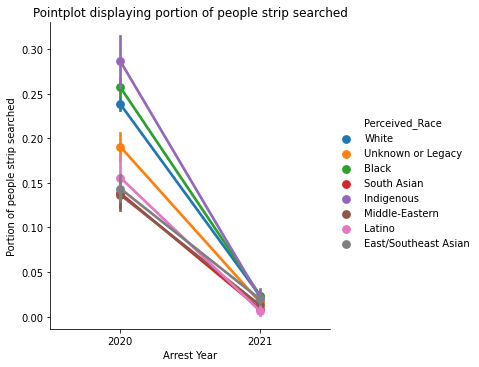

In [21]:
# Barplot of number of arrests between different races, grouped by sex
#sns.catplot(data = df, y = 'Perceived_Race', kind = 'count', hue = 'Sex')
#plt.title('Barplot displaying number of arrests for each perceived race')
#plt.xlabel('Number of arrests')

# Boxplot of number of stripsearch between races
sns.catplot(data=data, y = "Race", x = "StripSearch", kind="box")
plt.xlim(0, 350)
plt.title('Boxplot displaying number of stripsearch for each perceived race')
plt.ylabel('Perceived Race')

# Boxplot of number of stripsearch between age groups
sns.catplot(data=data, y = "AgeGroup", x = "StripSearch", hue = 'Sex', kind="box")
plt.xlim(0, 160)
plt.title('Boxplot displaying number of stripsearch for each age group')
plt.ylabel('Age Group')

# Barplot of number of arrests in each quarter
#sns.catplot(data = df, y = 'Arrest_Month', kind = 'count')
#plt.title('Barplot displaying number of arrests in each quarter')
#plt.xlabel('Number of arrests')
#plt.ylabel('Quarters of the year')

# Pointplot of percentage of people strip searched
sns.catplot(data = df, x = 'Sex', y = 'StripSearch', kind = 'point',
            hue = 'Perceived_Race')
plt.title('Pointplot displaying portion of people strip searched')
plt.xlabel('Sex')
plt.ylabel('Portion of people strip searched')

# Pointplot of percentage of people strip searched
sns.catplot(data = df, x = 'Arrest_Year', y = 'StripSearch', kind = 'point',
            hue = 'Perceived_Race')
plt.title('Pointplot displaying portion of people strip searched')
plt.xlabel('Arrest Year')
plt.ylabel('Portion of people strip searched')

# Barplot of number of arrests in different age group
#sns.catplot(data = df, y = 'Age_group__at_arrest_', kind = 'count')
#plt.title('Barplot displaying number of arrests in different age group')
#plt.xlabel('Number of arrests')
#plt.ylabel('Age Group')

Text(-83.075, 0.5, 'Perceived Race')

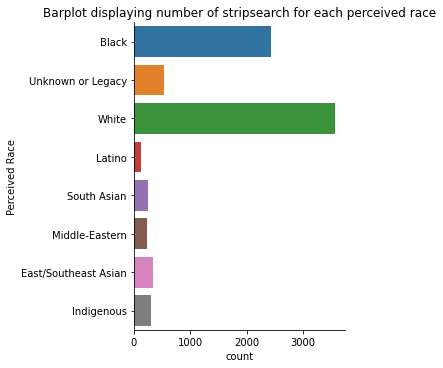

In [16]:
# Barplot of number of stripsearch between races
sns.catplot(data= df[df['StripSearch']==1], y = "Perceived_Race", kind="count")
plt.title('Barplot displaying number of stripsearch for each perceived race')
plt.ylabel('Perceived Race')

T-Test

In [ ]:
# t-test for number of strip searched among different gender
m = data[data['Sex'] == 'M']['StripSearch']
f = data[data['Sex'] == 'F']['StripSearch']
stats.ttest_ind(a=m, b=f, equal_var=True)

Ttest_indResult(statistic=3.291611631656379, pvalue=0.0011587995017533778)

In [ ]:
# t-test for number of arrests among different gender
m = data[data['Sex'] == 'M']['Arrest']
f = data[data['Sex'] == 'F']['Arrest']
stats.ttest_ind(a=m, b=f, equal_var=True)

Ttest_indResult(statistic=5.13360490086564, pvalue=6.203746418421583e-07)

In [ ]:
# t-test for number of strip searched betweem 2020 and 2021
year20 = data[data['Year'] == 2020]['StripSearch']
year21 = data[data['Year'] == 2021]['StripSearch']
stats.ttest_ind(a=year20, b=year21, equal_var=True)

Ttest_indResult(statistic=4.093600424660075, pvalue=5.9481106288335435e-05)

In [ ]:
# t-test for number of arrests betweem 2020 and 2021
year20 = data[data['Year'] == 2020]['Arrest']
year21 = data[data['Year'] == 2021]['Arrest']
stats.ttest_ind(a=year20, b=year21, equal_var=True)

Ttest_indResult(statistic=-0.15996450303340357, pvalue=0.8730544876686925)

In [ ]:
# t-test for number of strip searched among different youth
youth = data[data['Youth'] == 'Youth']['StripSearch']
notYouth = data[data['Youth'] == 'Not a youth']['StripSearch']
stats.ttest_ind(a=youth, b=notYouth, equal_var=True)

Ttest_indResult(statistic=-1.4711995430314846, pvalue=0.14265320107492713)

In [ ]:
# t-test for number of arrests among different youth
youth = data[data['Youth'] == 'Youth']['Arrest']
notYouth = data[data['Youth'] == 'Not a youth']['Arrest']
stats.ttest_ind(a=youth, b=notYouth, equal_var=True)

Ttest_indResult(statistic=-2.1992148890862286, pvalue=0.028894814979940328)

In [ ]:
# t-test for number of strip searched among Black and non Black
blackUnknown = data.loc[data['Race'].isin(['Black', 'Unknown or Legacy'])]['StripSearch']
nonBlack = data.loc[data['Race'].isin(['South Asian', 'Latino','White','Indigenous','Middle-Eastern','East/Southeast Asian'])]['StripSearch']
stats.ttest_ind(a=blackUnknown, b=nonBlack, equal_var=True)

Ttest_indResult(statistic=1.45339427851965, pvalue=0.14752644059038528)

ANOVA

In [ ]:
# One-way ANOVA for race
model = ols('StripSearch ~ C(Race)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

In [ ]:
# Tukey's test
score = list(data[data['Race'] == 'South Asian']['StripSearch']) + \
list(data[data['Race'] == 'Latino']['StripSearch']) + \
list(data[data['Race'] == 'Unknown or Legacy']['StripSearch']) + \
list(data[data['Race'] == 'Black']['StripSearch']) + \
list(data[data['Race'] == 'White']['StripSearch']) + \
list(data[data['Race'] == 'Indigenous']['StripSearch']) + \
list(data[data['Race'] == 'Middle-Eastern']['StripSearch']) + \
list(data[data['Race'] == 'East/Southeast Asian']['StripSearch'])

group = ['South Asian', 'Latino', 'Unknown or Legacy', 'Black', 'White',\
         'Indigenous', 'Middle-Eastern', 'East.Southeast Asian']

df = pd.DataFrame({'score': score,
                   'group': np.repeat(group, repeats = 28)})

# Perform Tukey's test
tukey = pairwise_tukeyhsd(endog = df['score'],
                          groups = df['group'],
                          alpha=0.05)

# Display results
print(tukey)

In [ ]:
# Two-way ANOVA for Sex and AgeGroup
model = ols('StripSearch ~ C(Sex) + C(AgeGroup) + C(Sex):C(AgeGroup)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

In [ ]:
# Plot interaction
fig = interaction_plot(x = data['AgeGroup'], trace = data['Sex'],
                       response = data['StripSearch'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Age Group')
plt.show()

Power Analysis

Effect size (Cohen's D) for stripsearch: 0.08165576200036011
Sample Size of nobs1: 4384.867 needed for other_ss
Actual size of other_ss: 47737
Sample Size of nobs2: 1609.845 needed for black_ss
Actual size of black_ss: 17526


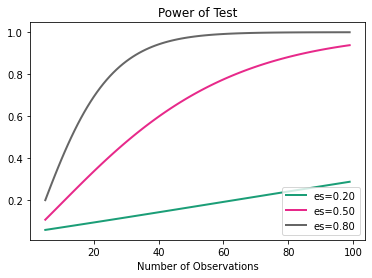

In [17]:
# Code for Cohen's D 

# Function to calculate the pooled standard deviation of 2 samples
def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

# function to calculate Cohen's d for independent samples
def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)

# Create two different datasets
black = df[df['Perceived_Race']=='Black']
other = df[df['Perceived_Race']!='Black']

black_ss = black['StripSearch']
other_ss = other['StripSearch']

# Conduct power analysis
effect_size = Cohens_d(black_ss, other_ss)
alpha = 0.05
power = 0.8
ratio_ =len(black_ss)/len(other_ss) # NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for stripsearch:',effect_size)

# Prior to computing a t-test to analyze whether stripsearch (outcome variable)
# differed between black people and other perceived races (two-level explanatory
# variable), we calculated the effect size of the explanatory variable using
# Cohen's D metric, which was 0.08.

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for other_ss') 
print('Actual size of other_ss:', len(other_ss))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for black_ss')
print('Actual size of black_ss:', len(black_ss))

# After obtaining the effect size, the required sample size was computed using
# the obtained effect size and establishing the statistical power at 80%. The
# results indicated that a sample size of 1610 was required for black people,
# while a sample size of 4385 was required for all other races combined. This
# study has more power than what was originally calculated because the
# sample size provided in the dataset are 17526 and 47737 respectively.

# Plot power curve
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

ANCOVA

In [ ]:
data.head()

# Compute ANCOVA

# The null hypothesis for this example:
# Individuals from all races have equal propability to be stripsearched upon
# arrest on average after accounting for the year.
ancova(data=data, dv='Prop_StripSearch', covar='Year', between='Race')

# Interpretation p-unc = “uncorrected p-value” for Race is less than 0.05. Thus,
# we reject the null hypothesis that each race results in the same probability
# to be stripsearched, even after controlling for the year of the arrest.

# We hypothesized that the perceived race would be able to predict the chance of
# being stripsearched upon arrests. From our results, we observed that there is
# statistically significant relationship between perceived race and proportion
# of arrests that were stripsearched when controlling for the year. This raises
# interesting insights as it suggests that a person's perceived race may be
# influencing whether he/she is stripsearched upon arrests.

,Source,SS,DF,F,p-unc,np2
0,Race,0.140413,7,4.489695,1.095496e-04,0.128053
1,Year,1.035149,1,231.691604,6.081872e-36,0.519847
2,Residual,0.956106,214,NaN,NaN,NaN


Logistic Regression

In [ ]:
data['HigherSSProp'] = data['Prop_StripSearch'] > data['Prop_StripSearch'].mean()
data.head()
df_log = data[['Year', 'Sex', 'HigherSSProp']]
# Convert categorical variables to numeric using one-hot encoding
df_log = pd.get_dummies(df_log, columns=['Sex'])
df_log.head()
# Isolate columns of interest
X = df_log.drop(['HigherSSProp', 'Sex_F'], axis=1)
y = df_log['HigherSSProp']
# Split training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)
# Apply logistic model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
# Print the coefficients
logit_model=sm.Logit(y_train, X_train)
result=logit_model.fit()
print(result.summary2())